In [25]:
import util
from importlib import reload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timezone
from numba import njit
import pickle
import os
import sqlite3
from dotenv import load_dotenv
import yfinance as yf
import strategies
load_dotenv()
util = reload(util)

In [17]:

kraken_coin_data = util.get_exchange_coins('kraken')
kraken_coin_ids = [coin['coin_id'] for coin in kraken_coin_data]
kraken_symbols = [coin['base'].lower() for coin in kraken_coin_data]
tradable_kraken_coins = util.get_tradable_kraken_coins()
all_data = util.get_all_ochl()

kraken_data = all_data[all_data['coin_id'].isin(kraken_coin_ids)]
coins_to_exclude = [
        'tether', 
        'usd-coin', 
        'true-usd', 
        'wrapped-bitcoin',
        'dai',
        'terra-luna',
        'ftx-token',
        'bora',
        'theta-fuel',
        'gifto',
        'amber',
        'cocos-bcx',
        'beldex',
        'usdc',
    ]
exclude_coins_symbol = [coin['base'].lower() for coin in kraken_coin_data if coin['coin_id'] in coins_to_exclude]
all_close_prices = util.get_col_pivot_from_all_ochl(type ='close',volume_threshold= 100000)
all_high_prices = util.get_col_pivot_from_all_ochl(type ='high', volume_threshold=100000)
all_low_prices = util.get_col_pivot_from_all_ochl(type ='low', volume_threshold=100000)
all_vol = util.get_col_pivot_from_all_ochl(type='volume' ,volume_threshold=100000)
kraken_columns = list(set(all_close_prices.columns).intersection(set(kraken_symbols))-set(exclude_coins_symbol))
all_kraken_close_prices = np.log(all_close_prices[kraken_columns])
all_kraken_high_prices = np.log(all_high_prices[kraken_columns])
all_kraken_low_prices = np.log(all_low_prices[kraken_columns])
all_kraken_vol = all_vol[kraken_columns]
kraken_ret = (util.transform_returns(kraken_data, volume_threshold=100000))
modified_ret = util.monotonic_tail_cleansing(kraken_ret[kraken_columns])
num_non_nan = modified_ret.count()
filter_columns = (num_non_nan[num_non_nan > 10000]).index
modified_ret = modified_ret[filter_columns]
kraken_trading_activity = np.power(modified_ret.rolling(24, min_periods=1).std()*all_kraken_vol, 2/3)
log_trading_activity = np.log1p(kraken_trading_activity)
start_date_in_sample = '2019-01-01'
end_date_in_sample = '2023-12-31'
start_date_out_of_sample = '2024-01-01'
def get_in_sample(df):
    return df.loc[start_date_in_sample:end_date_in_sample][filter_columns]
def get_out_of_sample(df):
    return df.loc[start_date_out_of_sample:][filter_columns]
in_sample_ret = get_in_sample(modified_ret)
in_sample_close_prices = get_in_sample(all_kraken_close_prices)
in_sample_high_prices = get_in_sample(all_kraken_high_prices)
in_sample_low_prices = get_in_sample(all_kraken_close_prices)
out_of_sample_ret = get_out_of_sample(modified_ret)
out_of_sample_close_prices = get_out_of_sample(all_kraken_close_prices)
out_of_sample_high_prices = get_out_of_sample(all_kraken_high_prices)
out_of_sample_low_prices = get_out_of_sample(all_kraken_low_prices)

In [18]:
def equal_weighting(signal):
    '''equal weighting of returns'''
    port = signal.div(signal.abs().sum(axis=1),axis=0)
    return port.fillna(0)

## Channel Breakout

In [26]:
import numpy as np
import pandas as pd
from numba import njit

# --- Sparse table for rolling maximum ---
@njit
def build_sparse_table_max(arr):
    n = arr.shape[0]
    # Precompute logarithms
    log = np.empty(n + 1, dtype=np.int64)
    log[1] = 0
    for i in range(2, n + 1):
        log[i] = log[i // 2] + 1
    k = log[n] + 1  # number of levels
    st = np.empty((n, k), dtype=arr.dtype)
    for i in range(n):
        st[i, 0] = arr[i]
    j = 1
    while (1 << j) <= n:
        i = 0
        while i + (1 << j) - 1 < n:
            # Each entry is the maximum of two overlapping intervals
            left_val = st[i, j - 1]
            right_val = st[i + (1 << (j - 1)), j - 1]
            st[i, j] = left_val if left_val >= right_val else right_val
            i += 1
        j += 1
    return st, log

@njit(inline='always')
def query_max(st, log, L, R):
    j = log[R - L + 1]
    left_interval = st[L, j]
    right_interval = st[R - (1 << j) + 1, j]
    return left_interval if left_interval >= right_interval else right_interval

@njit
def dynamic_rolling_max_sparse(arr, win_sizes):
    n = arr.shape[0]
    res = np.empty(n, dtype=arr.dtype)
    st, log = build_sparse_table_max(arr)
    for i in range(n):
        w = int(win_sizes[i])
        L = i - w + 1
        if L < 0:
            L = 0
        res[i] = query_max(st, log, L, i)
    return res

# --- Sparse table for rolling minimum ---
@njit
def build_sparse_table_min(arr):
    n = arr.shape[0]
    log = np.empty(n + 1, dtype=np.int64)
    log[1] = 0
    for i in range(2, n + 1):
        log[i] = log[i // 2] + 1
    k = log[n] + 1
    st = np.empty((n, k), dtype=arr.dtype)
    for i in range(n):
        st[i, 0] = arr[i]
    j = 1
    while (1 << j) <= n:
        i = 0
        while i + (1 << j) - 1 < n:
            left_val = st[i, j - 1]
            right_val = st[i + (1 << (j - 1)), j - 1]
            st[i, j] = left_val if left_val <= right_val else right_val
            i += 1
        j += 1
    return st, log

@njit(inline='always')
def query_min(st, log, L, R):
    j = log[R - L + 1]
    left_interval = st[L, j]
    right_interval = st[R - (1 << j) + 1, j]
    return left_interval if left_interval <= right_interval else right_interval

@njit
def dynamic_rolling_min_sparse(arr, win_sizes):
    n = arr.shape[0]
    res = np.empty(n, dtype=arr.dtype)
    st, log = build_sparse_table_min(arr)
    for i in range(n):
        w = int(win_sizes[i])
        L = i - w + 1
        if L < 0:
            L = 0
        res[i] = query_min(st, log, L, i)
    return res

# --- Main business time signal function ---
def buy_high_sell_low_businesstime(buy_prices, sell_prices, log_trading_activity, enter_lookback=90000, exit_lookback=800):
    # Precompute dynamic window sizes as NumPy arrays.
    enter_lookback_np = np.ceil(enter_lookback / log_trading_activity).to_numpy()
    exit_lookback_np  = np.ceil(exit_lookback / log_trading_activity).to_numpy()
    
    # Convert prices to NumPy arrays.
    buy_np = buy_prices.to_numpy()
    sell_np = sell_prices.to_numpy()
    
    n_rows, n_cols = buy_np.shape
    dynamic_max_np = np.empty_like(buy_np)
    dynamic_min_np = np.empty_like(sell_np)
    
    # Loop over each column (you can further parallelize this loop if needed)
    for col in range(n_cols):
        dynamic_max_np[:, col] = dynamic_rolling_max_sparse(buy_np[:, col], enter_lookback_np[:, col])
        dynamic_min_np[:, col] = dynamic_rolling_min_sparse(sell_np[:, col], exit_lookback_np[:, col])
    
    # Reconstruct DataFrames.
    dynamic_max = pd.DataFrame(dynamic_max_np, index=buy_prices.index, columns=buy_prices.columns)
    dynamic_min = pd.DataFrame(dynamic_min_np, index=sell_prices.index, columns=sell_prices.columns)
    
    # Generate trading signals.
    enter_signal = (dynamic_max == buy_prices)
    exit_signal  = (dynamic_min == sell_prices)
    
    position = pd.DataFrame(
        np.where(exit_signal, 0, np.where(enter_signal, 1, np.nan)),
        index=buy_prices.index,
        columns=buy_prices.columns
    )
    position = position.ffill().fillna(0)
    
    return equal_weighting(position)  # assuming equal_weighting is defined elsewhere


Corr with BTC (before purification):  0.7788296530765937
BTC Beta:  1.0484872752968502
Corr with BTC:  -0.013758468048996173
Average Turnover:  0.0015210231406090821
Sharpe Ratio:  0.055438326489044315
Max Drawdown:  1.3146303753012285
Time Exposure Ratio:  0.5258534136546185
Max Drawdown Duration:  1216.75 days


(0.0015210231406090821, 0.055438326489044315, 1.3146303753012285, 1216.75)

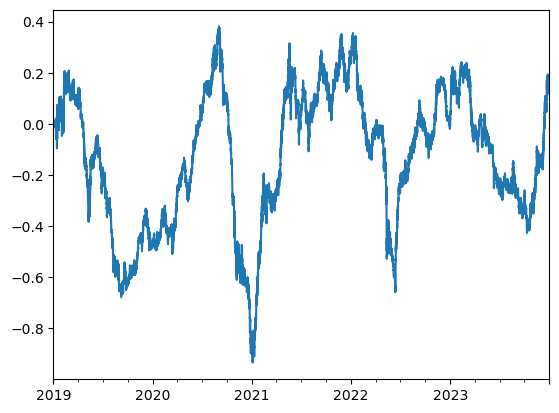

In [27]:
util.to_sharpe(
    buy_high_sell_low_businesstime(
        in_sample_high_prices,in_sample_low_prices, log_trading_activity, 90000, 2400), in_sample_ret, plot=True, purify=True)

In [17]:
port = buy_high_sell_low_businesstime(all_kraken_high_prices,all_kraken_low_prices, log_trading_activity, 2740*12, 1200)

Corr with BTC (before purification):  0.66772469834631
BTC Beta:  1.331788686865014
Corr with BTC:  -0.03755481572678279
Average Turnover:  0.0077048224073206825
Sharpe Ratio:  -0.20964779379959303
Max Drawdown:  0.9547843297903726
Time Exposure Ratio:  0.5118405852907201
Max Drawdown Duration:  74.0 days


(0.0077048224073206825, -0.20964779379959303, 0.9547843297903726, 74.0)

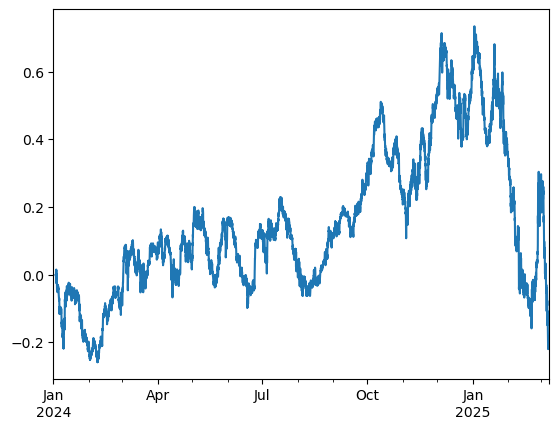

In [18]:
util.to_sharpe(port.loc['2024-01-01':], modified_ret.loc['2024-01-01':], plot=True, purify=True)

In [23]:
import random
import copy

def split_list_equal(lt, random_seed=None):
    """Splits lst into three approximately equal-sized disjoint lists with a fixed random seed."""
    lt = list(lt)  # Ensure lst is a list
    lst = lt.copy()
    if random_seed is not None:
        random.seed(random_seed)  # Set seed for reproducibility
    
    random.shuffle(lst)  # Shuffle in place
    n = len(lst)
    size1, size2 = n // 3, (n // 3) + (n % 3 > 0)  # Distribute extra elements
    size3 = n - (size1 + size2)
    
    return lst[:size1], lst[size1:size1+size2], lst[size1+size2:]

list1, list2, list3 = split_list_equal(all_kraken_high_prices.columns, random_seed=42)


In [24]:
port = buy_high_sell_low_businesstime(all_kraken_high_prices[list3],all_kraken_low_prices[list3], log_trading_activity[list3], 2740*12, 1200)


Average Turnover:  0.012891556189476154
Sharpe Ratio:  1.425443654364946
Max Drawdown:  1.230917137178375
Time Exposure Ratio:  0.3769734308817867
Max Drawdown Duration:  71.75 days


(0.012891556189476154, 1.425443654364946, 1.230917137178375, 71.75)

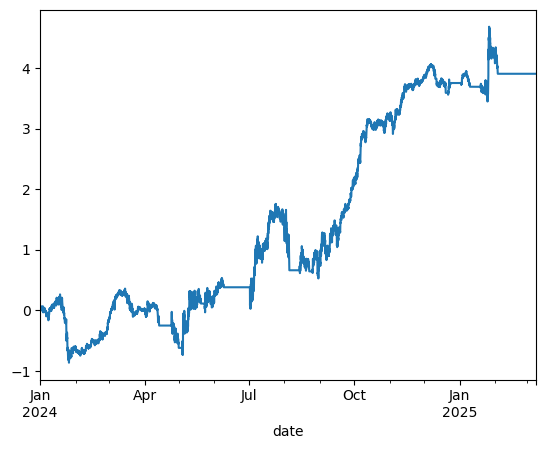

In [25]:
util.to_sharpe(port.loc['2024-01-01':], modified_ret[list3].loc['2024-01-01':], purify=True, plot=True)

In [ ]:
def grid_search_channel_breakout_businesstime(enter_prices, exit_prices, ret):
    exit_lookback = [400, 600, 800, 1000, 1200]
    enter_lookback = [10000, 30000, 60000, 90000, 100000]
    results = []
    
    for i in enter_lookback:
        for j in exit_lookback:
            weightings = buy_high_sell_low_businesstime(enter_prices, exit_prices, log_trading_activity, i, j)
            avg_to, sharpe, drawdown, drawdown_duration = util.to_sharpe(weightings, ret, plot = False, purify = True)
            results.append((i,j,avg_to, sharpe, drawdown, drawdown_duration))
    df = pd.DataFrame(results, columns = ['enter_lookback','exit_lookback','avg_to','sharpe', "drawdown", "drawdown_duration (days)"])
    return df
results = grid_search_channel_breakout_businesstime(in_sample_low_prices, in_sample_high_prices, in_sample_ret)

Corr with BTC (before purification):  0.7423917797320007
BTC Beta:  1.0562256888251225
Corr with BTC (before purification):  0.742592519607623
BTC Beta:  1.054993531707128
Corr with BTC (before purification):  0.7429834542935371
BTC Beta:  1.0539793166022107
Corr with BTC (before purification):  0.743638789904104
BTC Beta:  1.0535306394466435
Corr with BTC (before purification):  0.7447267687015188
BTC Beta:  1.0527092437067778
Corr with BTC (before purification):  0.7412595953345292
BTC Beta:  1.0566058268274838
Corr with BTC (before purification):  0.7409637107413861
BTC Beta:  1.0546809337461323
Corr with BTC (before purification):  0.7410823113445922
BTC Beta:  1.053195432149595
Corr with BTC (before purification):  0.7415471550444667
BTC Beta:  1.0527473321761462
Corr with BTC (before purification):  0.7425731813991692
BTC Beta:  1.0517900132617772
Corr with BTC (before purification):  0.7403645894822407
BTC Beta:  1.0558359094536165
Corr with BTC (before purification):  0.7400144

In [ ]:
results.sort_values(by='sharpe', ascending=False).head(10)

,enter_lookback,exit_lookback,avg_to,sharpe,drawdown,drawdown_duration (days)
19,90000,1200,0.001507,1.423773,1.310910,426.416667
14,60000,1200,0.001644,1.415472,1.311272,426.416667
8,30000,1000,0.002018,1.413359,1.326917,428.083333
18,90000,1000,0.001566,1.409886,1.326555,426.416667
13,60000,1000,0.001708,1.405851,1.326917,426.416667
24,100000,1200,0.001483,1.402058,1.336315,426.416667
9,30000,1200,0.001915,1.401997,1.311272,428.083333
7,30000,800,0.002154,1.395104,1.328202,428.166667
23,100000,1000,0.001538,1.389038,1.337070,426.416667
12,60000,800,0.001797,1.384908,1.328202,428.000000


<Axes: xlabel='exit_lookback', ylabel='enter_lookback'>

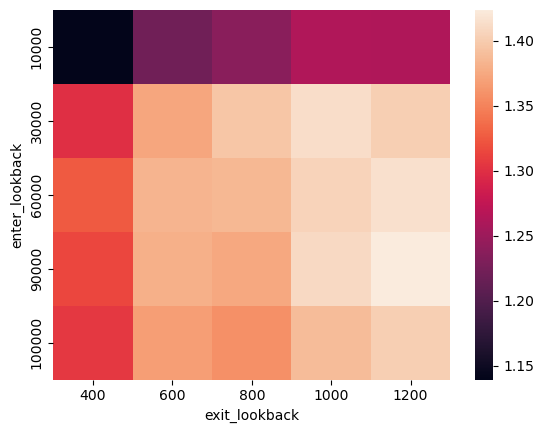

In [ ]:
import seaborn as sns
sns.heatmap(results.pivot_table(index='enter_lookback', columns='exit_lookback', values='sharpe'))

In [ ]:
def buy_high_sell_low(buy_prices, sell_prices, enter_lookback = 2760, exit_lookback = 32):
    enter_signal = buy_prices.rolling(enter_lookback, min_periods = 1).max() == buy_prices
    exit_signal = sell_prices.rolling(exit_lookback, min_periods = 1).min() == sell_prices
    position = pd.DataFrame(
        np.where(exit_signal, 0, np.where(enter_signal, 1, np.nan)),
        index = buy_prices.index,
        columns = buy_prices.columns
    )
    position = position.ffill().fillna(0)
    return equal_weighting(position)

def grid_search_blsh(enter_prices, exit_prices, ret):
    enter_lookback = [ 2700, 2750, 2800, 2850, 2900]
    exit_lookback = [24, 26, 28,30, 32, 34, 36, 38, 40]
    results = []
    
    for i in enter_lookback:
        for j in exit_lookback:
            weightings = buy_high_sell_low(enter_prices, exit_prices, i, j)
            avg_to, sharpe, drawdown, drawdown_duration = util.to_sharpe(weightings, ret, plot = False)
            results.append((i,j,avg_to, sharpe, drawdown, drawdown_duration))
    df = pd.DataFrame(results, columns = ['enter_lookback','exit_lookback','avg_to','sharpe', "drawdown", "drawdown_duration (days)"])
    return df
port = buy_high_sell_low(in_sample_low_prices, in_sample_high_prices)

In [27]:
results = grid_search_blsh(in_sample_high_prices, in_sample_low_prices, in_sample_ret)

In [ ]:
results.sort_values('sharpe', ascending=False).where(lambda x: x['avg_to'] > 0.01).dropna().head(20)

,enter_lookback,exit_lookback,avg_to,sharpe,drawdown,drawdown_duration (days)
13,2750,32,0.032465,2.344164,1.499116,263.458333
22,2800,32,0.032277,2.343919,1.499116,263.458333
4,2700,32,0.032693,2.311644,1.499116,263.416667
11,2750,28,0.035670,2.279972,1.827379,368.750000
20,2800,28,0.035459,2.279103,1.865624,370.291667
40,2900,32,0.031849,2.267876,1.550527,264.333333
2,2700,28,0.035903,2.260163,1.862376,369.166667
16,2750,38,0.028750,2.241356,1.523097,245.625000
25,2800,38,0.028595,2.240075,1.523097,245.333333
17,2750,40,0.027694,2.238467,1.533729,265.250000


Corr with BTC (before purification):  0.16134215738538263
BTC Beta:  0.5733286150139952
Corr with BTC:  -0.009530470757076541
Average Turnover:  0.03239718693604279
Sharpe Ratio:  2.1514864443166672
Max Drawdown:  1.916936928157273
Time Exposure Ratio:  0.2772091748149502
Max Drawdown Duration:  263.2916666666667 days


(0.03239718693604279, 2.1514864443166672, 1.916936928157273, 263.2916666666667)

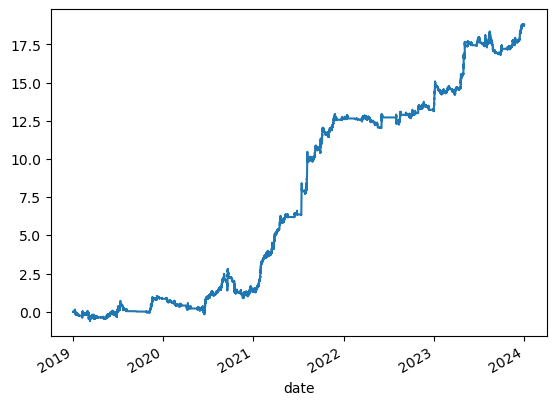

In [ ]:
reload(util)
util.to_sharpe(buy_high_sell_low(in_sample_high_prices, in_sample_low_prices, 2760, 32), in_sample_ret, plot=True, purify=True)

Corr with BTC (before purification):  0.18254965156127154
BTC Beta:  1.0035861850773724
Corr with BTC:  -0.006068596894807587
Average Turnover:  0.052363688253238304
Sharpe Ratio:  1.231317648204317
Max Drawdown:  2.232722695272162
Time Exposure Ratio:  0.39670773969965345
Max Drawdown Duration:  146.20833333333334 days


(0.052363688253238304,
 1.231317648204317,
 2.232722695272162,
 146.20833333333334)

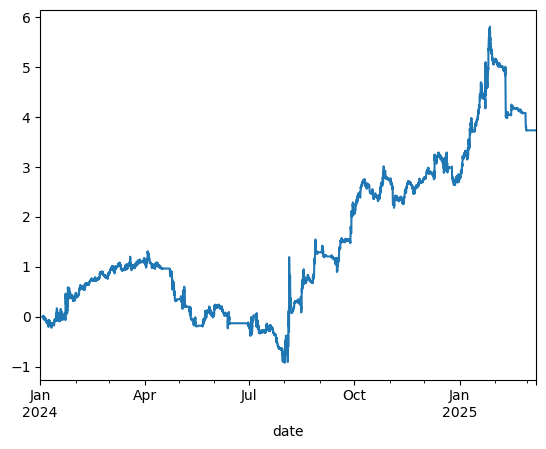

In [ ]:
util.to_sharpe(buy_high_sell_low(out_of_sample_high_prices, out_of_sample_low_prices, 2760, 32), out_of_sample_ret, plot=True, purify=True)

<Axes: xlabel='exit_lookback', ylabel='enter_lookback'>

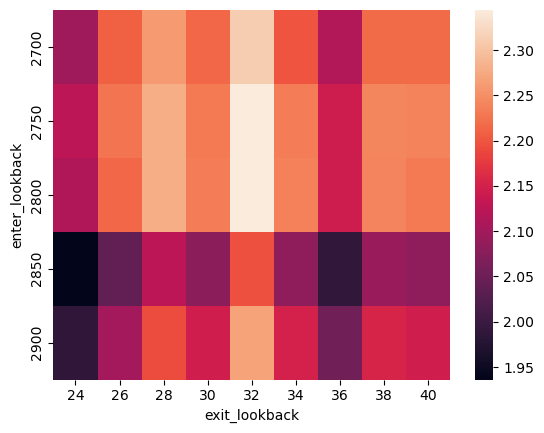

In [ ]:
import seaborn as sns
sns.heatmap(results.pivot_table(index='enter_lookback', columns='exit_lookback', values='sharpe'))

In [ ]:
def zscore_reversal_long(ret, enter_lookback=1344, exit_lookback=12, enter_zscore = -3, exit_zscore = 1 ):

    long_enter_zscore= (ret-ret.rolling(window=enter_lookback, min_periods=1).mean()).divide(ret.rolling(window=enter_lookback, min_periods=1).std())
    long_exit_zscore  = (ret-ret.rolling(window=exit_lookback, min_periods=1).mean()).divide(ret.rolling(window=exit_lookback, min_periods=1).std())


    position = pd.DataFrame(
        np.where(long_enter_zscore <= enter_zscore, 1, np.where(long_exit_zscore > exit_zscore, 0, np.nan)),
        # np.where(long_exit_zscore > exit_zscore, 0, np.where(long_enter_zscore <= enter_zscore, 1, np.nan)),
        index=ret.index,
        columns=ret.columns
    )
    position = position.ffill().fillna(0)
    
    return equal_weighting(position)

port = zscore_reversal_long(in_sample_ret)

In [ ]:

def zscore_reversal_long_gridsearch(ret):
    enter_lookback = [12, 15, 1344]
    exit_lookback = [12, 15, 24, 168, 672, 1344, 1500]
    enter_zscore = [-3, -2.5]
    exit_zscore = [0.5, 1]
    results = []
    
    for i in enter_lookback:
        for j in exit_lookback:
            for k in enter_zscore:
                for l in exit_zscore:
                    if enter_zscore > exit_zscore:
                        continue
                    weightings = zscore_reversal_long(ret,i,j,k,l)
                    avg_to, sharpe, drawdown, drawdown_duration = util.to_sharpe(weightings, ret, plot = False)
                    results.append((i,j,k,l,avg_to, sharpe, drawdown, drawdown_duration))
    df = pd.DataFrame(results, columns = ['enter_lookback','exit_lookback','enter_zscore','exit_zscore','avg_to','sharpe', "drawdown", "drawdown_duration (days)"])
    return df
results = zscore_reversal_long_gridsearch(in_sample_ret)

In [ ]:
results.sort_values('sharpe', ascending=False).where(lambda x: x['avg_to'] > 0.01).dropna().head(10)

,enter_lookback,exit_lookback,enter_zscore,exit_zscore,avg_to,sharpe,drawdown,drawdown_duration (days)
61,1344,15,-3.0,1.0,0.198552,0.133736,12.597464,799.166667
65,1344,24,-3.0,1.0,0.194142,-0.058277,11.860408,802.833333
57,1344,12,-3.0,1.0,0.201577,-0.203251,13.356997,875.000000
25,12,1500,-3.0,1.0,0.021141,-0.712217,3.939533,1712.125000
69,1344,168,-3.0,1.0,0.207415,-0.805657,13.232820,962.916667
21,12,1344,-3.0,1.0,0.021144,-0.822440,3.630716,1725.583333
63,1344,15,-2.5,1.0,0.273168,-0.836817,16.692434,873.541667
20,12,1344,-3.0,0.5,0.022772,-0.900523,3.903724,1725.583333
60,1344,15,-3.0,0.5,0.240582,-0.907154,15.820875,981.500000
67,1344,24,-2.5,1.0,0.265148,-0.910467,16.208045,873.541667


## Mean Reversion

In [53]:
def buy_low_sell_high(buy_prices, sell_prices, enter_lookback = 12, exit_lookback = 12):
    enter_signal = buy_prices.rolling(enter_lookback, min_periods = 1).min() == buy_prices
    exit_signal = sell_prices.rolling(exit_lookback, min_periods = 1).max() == sell_prices
    position = pd.DataFrame(
        np.where(exit_signal, 0, np.where(enter_signal, 1, np.nan)),
        index = buy_prices.index,
        columns = buy_prices.columns
    )
    position = position.ffill().fillna(0)
    return equal_weighting(position)
def grid_search_mr(enter_prices, exit_prices, ret):
    enter_lookback = [1000, 1800,  2400, 3200, 4800]
    exit_lookback = [24, 80, 100, 160, 240]
    results = []
    
    for i in enter_lookback:
        for j in exit_lookback:
            weightings = buy_low_sell_high(enter_prices, exit_prices, i, j)
            avg_to, sharpe, drawdown, drawdown_duration = util.to_sharpe(weightings, ret, plot = False, purify=True)
            results.append((i,j,avg_to, sharpe, drawdown, drawdown_duration))
    df = pd.DataFrame(results, columns = ['enter_lookback','exit_lookback','avg_to','sharpe', "drawdown", "drawdown_duration (days)"])
    return df
results = grid_search_mr(in_sample_low_prices, in_sample_high_prices, in_sample_ret)

In [54]:
results.sort_values('sharpe', ascending=False).where(lambda x: x['avg_to'] > 0.01).dropna().head(10)

,enter_lookback,exit_lookback,avg_to,sharpe,drawdown,drawdown_duration (days)
21,4800.0,80.0,0.015685,0.269131,6.964101,1306.708333
22,4800.0,100.0,0.013649,0.261825,7.169433,1308.458333
12,2400.0,100.0,0.015836,0.255189,6.519443,1308.458333
11,2400.0,80.0,0.018229,0.237393,6.939739,1306.708333
16,3200.0,80.0,0.017031,0.236570,7.010876,1306.708333
17,3200.0,100.0,0.014781,0.234230,7.101189,1308.458333
1,1000.0,80.0,0.023199,0.229967,6.105119,1233.708333
2,1000.0,100.0,0.020165,0.199894,4.468444,1233.708333
7,1800.0,100.0,0.017134,0.187177,5.959637,1308.458333
6,1800.0,80.0,0.019706,0.148874,6.612315,1306.708333


In [1]:
import seaborn as sns
sns.heatmap(results.pivot_table(index='enter_lookback', columns='exit_lookback', values='sharpe'))

NameError: name 'results' is not defined